<a href="https://colab.research.google.com/github/NotYeshwanthReddy/CrackSegmentation/blob/main/Crack_Segmentation_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!cp "/content/drive/MyDrive/Projects/Pakkanodi Assignments/Crack Detection/Crack_Segmentation_Dataset.zip" "./Crack_Segmentation_Dataset.zip"
# ! rm -r "Crack_Segmentation_Dataset"
! unzip "Crack_Segmentation_Dataset.zip"

In [ ]:
import os

images_dir = "./Crack_Segmentation_Dataset/images/"
masks_dir = "./Crack_Segmentation_Dataset/masks/"

image_paths = sorted(os.listdir(images_dir))
mask_paths = sorted(os.listdir(masks_dir))

print(len(image_paths),
      len(mask_paths))

11298 11316


In [ ]:
image_paths_set = set(image_paths)
mask_paths_set = set(mask_paths)

total_data = image_paths_set.intersection(mask_paths_set)

In [ ]:
unwanted_files = list(mask_paths_set.difference(total_data))
unwanted_files.extend(list(image_paths_set.difference(total_data)))
print(unwanted_files)

import os
for uf in unwanted_files:
  try:
    os.remove(masks_dir+uf)
  except:
    pass
  try:
    os.remove(images_dir+uf)
  except:
    pass

del image_paths, mask_paths, image_paths_set, mask_paths_set, unwanted_files

['Rissbilder_for_Florian_9S6A2895_0_520_3840_4506 (1).jpg', 'Rissbilder_for_Florian_9S6A2894_2423_46_3033_3668 (2).jpg', 'Rissbilder_for_Florian_9S6A2895_1054_2017_2605_3001 (1).jpg', 'Rissbilder_for_Florian_9S6A2894_2274_588_3314_3190 (2).jpg', 'Rissbilder_for_Florian_9S6A2894_2274_588_3314_3190 (1).jpg', 'Rissbilder_for_Florian_9S6A2895_0_0_3840_5760 (1).jpg', 'Rissbilder_for_Florian_9S6A2895_1052_1345_2485_3231 (1).jpg', 'Rissbilder_for_Florian_9S6A2894_23_591_3752_3205 (2).jpg', 'Rissbilder_for_Florian_9S6A2894_23_591_3752_3205 (1).jpg', 'Rissbilder_for_Florian_9S6A2894_250_692_1976_2604 (1).jpg', 'Rissbilder_for_Florian_9S6A2894_2946_1337_2635_2361 (1).jpg', 'Rissbilder_for_Florian_9S6A2894_2946_1337_2635_2361 (2).jpg', 'Rissbilder_for_Florian_9S6A2894_250_692_1976_2604 (2).jpg', 'Rissbilder_for_Florian_9S6A2895_0_0_3840_5760 (2).jpg', 'Rissbilder_for_Florian_9S6A2894_2423_46_3033_3668 (1).jpg', 'Rissbilder_for_Florian_9S6A2895_1054_2017_2605_3001 (2).jpg', 'Rissbilder_for_Florian

In [ ]:
image_paths = sorted(os.listdir(images_dir))
mask_paths = sorted(os.listdir(masks_dir))

print(len(image_paths),
      len(mask_paths))

print("Images: ",image_paths[:5])
print("Masks: ",mask_paths[:5])

11298 11298
Images:  ['CFD_001.jpg', 'CFD_002.jpg', 'CFD_003.jpg', 'CFD_004.jpg', 'CFD_005.jpg']
Masks:  ['CFD_001.jpg', 'CFD_002.jpg', 'CFD_003.jpg', 'CFD_004.jpg', 'CFD_005.jpg']


# Data Augmentation

In [ ]:
import os
import random
from PIL import Image
import imgaug.augmenters as iaa
import numpy as np

In [ ]:
def augment_images_and_masks(img_paths, mask_paths, save_dir="./augmented_Crack_Segmentation_Dataset/"):
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)
      os.makedirs(save_dir+"images/")
      os.makedirs(save_dir+"masks/")

    for img_path, mask_path in zip(img_paths, mask_paths):
      img = Image.open(img_path)
      mask = Image.open(mask_path)

      # Rotate the image by 90 degrees
      rotated_img = img.rotate(15)
      rotated_mask = mask.rotate(15)

      # Flip the image horizontally
      flipped_horizontally_img = img.transpose(Image.FLIP_LEFT_RIGHT)
      flipped_horizontally_mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

      # Flip the image vertically
      flipped_vertically_img = img.transpose(Image.FLIP_TOP_BOTTOM)
      flipped_vertically_mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

      # Save the transformed images as separate files
      img.save(save_dir+"images/"+"original_"+img_path.split("/")[-1])
      mask.save(save_dir+"masks/"+"original_"+mask_path.split("/")[-1])
      rotated_img.save(save_dir+"images/"+"rotated_"+img_path.split("/")[-1])
      rotated_mask.save(save_dir+"masks/"+"rotated_"+mask_path.split("/")[-1])
      flipped_horizontally_img.save(save_dir+"images/"+"flipped_horizontally_"+img_path.split("/")[-1])
      flipped_horizontally_mask.save(save_dir+"masks/"+"flipped_horizontally_"+mask_path.split("/")[-1])
      flipped_vertically_img.save(save_dir+"images/"+"flipped_vertically_"+img_path.split("/")[-1])
      flipped_vertically_mask.save(save_dir+"masks/"+"flipped_vertically_"+mask_path.split("/")[-1])


In [ ]:
from tqdm import tqdm

def batch_processing(image_dir, mask_dir, batchsize):
  image_paths = sorted(os.listdir(images_dir))
  mask_paths = sorted(os.listdir(masks_dir))

  image_paths = [image_dir+f for f in image_paths]
  mask_paths = [mask_dir+f for f in mask_paths]

  for i in tqdm(range(0, len(image_paths), batchsize)):
    if i+batchsize<len(image_paths):
      batch_image_paths = image_paths[i:i+batchsize]
      batch_mask_paths = mask_paths[i:i+batchsize]
    else:
      batch_image_paths = image_paths[i:i+batchsize]
      batch_mask_paths = mask_paths[i:i+batchsize]

    try:
      augment_images_and_masks(batch_image_paths, batch_mask_paths)
    except Exception as e:
      print("Error in augmentation,\nSkipping {} : {}".format(i, i+batchsize))
      print(e)


In [ ]:
images_dir = "./Crack_Segmentation_Dataset/images/"
masks_dir = "./Crack_Segmentation_Dataset/masks/"

batch_processing(images_dir, masks_dir, batchsize=100)

100%|██████████| 113/113 [07:29<00:00,  3.98s/it]


### Graph

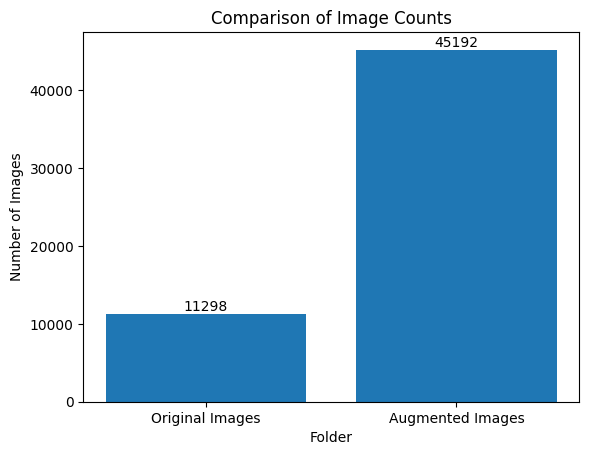

In [ ]:
import os
import matplotlib.pyplot as plt

original_images = "Crack_Segmentation_Dataset/images"
augmented_images = "augmented_Crack_Segmentation_Dataset/images"

original_images_count = len([filename for filename in os.listdir(original_images)])
augmented_images_count = len([filename for filename in os.listdir(augmented_images)])

fig, ax = plt.subplots()
bars = ax.bar(['Original Images', 'Augmented Images'], [original_images_count, augmented_images_count])
ax.set_xlabel('Folder')
ax.set_ylabel('Number of Images')
ax.set_title('Comparison of Image Counts')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.show()


### Visualization

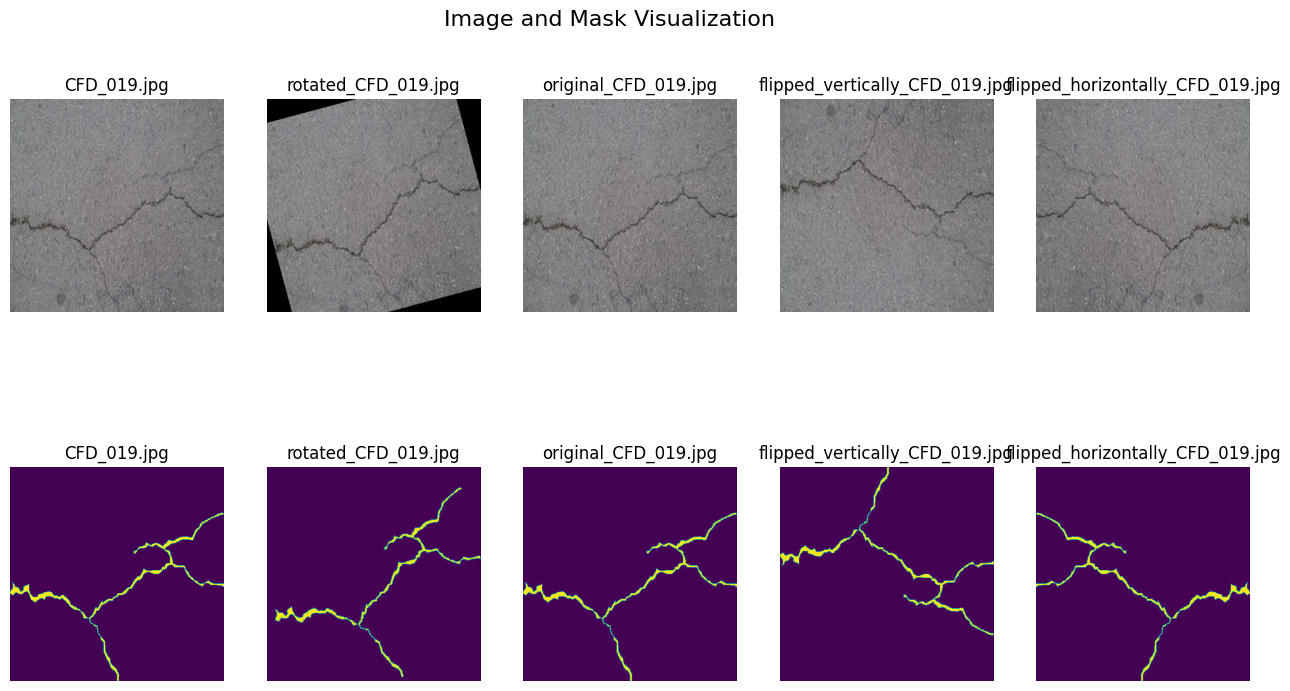

In [ ]:
import matplotlib.pyplot as plt
! rm -r visualize/

img_id = 18

augment_images_and_masks(["./Crack_Segmentation_Dataset/images/"+image_paths[img_id]],
                         ["./Crack_Segmentation_Dataset/masks/"+mask_paths[img_id]],
                         save_dir="./visualize/")


import shutil

src_path = "./Crack_Segmentation_Dataset/images/"+image_paths[img_id]
dst_path = "./visualize/images/"+image_paths[img_id]
shutil.copy(src_path, dst_path)
src_path = "./Crack_Segmentation_Dataset/masks/"+image_paths[img_id]
dst_path = "./visualize/masks/"+image_paths[img_id]
shutil.copy(src_path, dst_path)

images_dir = "./visualize/images/"
masks_dir = "./visualize/masks/"

# Get a list of all image files in the directories
image_files = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
mask_files = [os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))]

# Create a 2x4 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

# Iterate over the image and mask files and plot them in the subplots
for i in range(len(image_files)):
    # Load the image and mask
    img = Image.open(image_files[i])
    mask = Image.open(mask_files[i])

    # Plot the image in the top row
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(os.path.basename(image_files[i]))

    # Plot the mask in the bottom row
    axs[1, i].imshow(mask)
    axs[1, i].axis('off')
    axs[1, i].set_title(os.path.basename(mask_files[i]))

# Set the title of the plot
fig.suptitle('Image and Mask Visualization', fontsize=16)

# Adjust the spacing between subplots to prevent overlap of title and axis labels
plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.4)

# Show the plot
plt.show()


# Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device}" device.')

Currently using "cuda" device.


## Model Config

In [ ]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

batch_size = 20
image_size = 256
num_classes = 1
epochs = 3
path = r'seg_model.pth'

## Data

## Train Test split

In [ ]:
path_images = r'./augmented_Crack_Segmentation_Dataset/images/'
path_masks = r'./augmented_Crack_Segmentation_Dataset/masks/'

path_images = r'./Crack_Segmentation_Dataset/images/'
path_masks = r'./Crack_Segmentation_Dataset/masks/'

## be sure to match jpg/png to data set being used!
images_paths = glob(path_images + '*.jpg')
masks_paths = glob(path_masks + '*.jpg')

images_paths = sorted([str(p) for p in images_paths])
masks_paths = sorted([str(p) for p in masks_paths])

df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})

df.sample(2)

,images,masks
9648,./Crack_Segmentation_Dataset/images/cracktree2...,./Crack_Segmentation_Dataset/masks/cracktree20...
9647,./Crack_Segmentation_Dataset/images/cracktree2...,./Crack_Segmentation_Dataset/masks/cracktree20...


In [ ]:
df

,images,masks
0,./Crack_Segmentation_Dataset/images/CFD_001.jpg,./Crack_Segmentation_Dataset/masks/CFD_001.jpg
1,./Crack_Segmentation_Dataset/images/CFD_002.jpg,./Crack_Segmentation_Dataset/masks/CFD_002.jpg
2,./Crack_Segmentation_Dataset/images/CFD_003.jpg,./Crack_Segmentation_Dataset/masks/CFD_003.jpg
3,./Crack_Segmentation_Dataset/images/CFD_004.jpg,./Crack_Segmentation_Dataset/masks/CFD_004.jpg
4,./Crack_Segmentation_Dataset/images/CFD_005.jpg,./Crack_Segmentation_Dataset/masks/CFD_005.jpg
...,...,...
11293,./Crack_Segmentation_Dataset/images/noncrack_n...,./Crack_Segmentation_Dataset/masks/noncrack_no...
11294,./Crack_Segmentation_Dataset/images/noncrack_n...,./Crack_Segmentation_Dataset/masks/noncrack_no...
11295,./Crack_Segmentation_Dataset/images/noncrack_n...,./Crack_Segmentation_Dataset/masks/noncrack_no...
11296,./Crack_Segmentation_Dataset/images/noncrack_n...,./Crack_Segmentation_Dataset/masks/noncrack_no...


In [ ]:
## changed to define test size as % of dataset instead of set value
# test_size = 0.30* data size

train, test = train_test_split(df, test_size=0.25, shuffle=True, random_state=seed)
train, valid = train_test_split(train, test_size=0.20, shuffle=True, random_state=seed)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 6778, validation size: 1695 and test size: 2825


## Image Transform

In [ ]:
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((image_size, image_size)),
    # add some color augmentations manually if needed
    T.ToTensor()
])

## Crack Detection Model

In [ ]:
class CrackDataset(Dataset):
    def __init__(self, dataset, transforms=train_transforms):
        self.dataset = dataset.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
        row = self.dataset.loc[ix].squeeze()
        image_path = row['images']
        mask_path = row['masks']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = self.transforms(image).float()

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (image_size, image_size))
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)

        # mask_tensor /= 255.

        return image_tensor, mask_tensor

    def collate_fn(self, batch):
        images, masks = tuple(zip(*batch))
        images = [img[None] for img in images]
        masks = [msk[None] for msk in masks]
        images, masks = [torch.cat(i).to(device) for i in [images, masks]]
        return images, masks

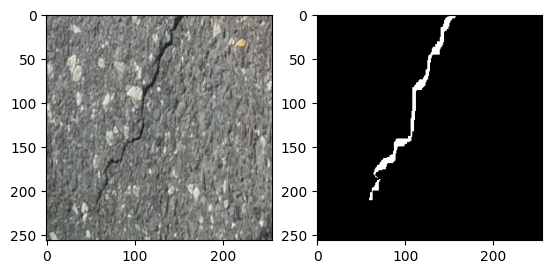

In [ ]:
ds = CrackDataset(train)
plt.subplot(121)
plt.imshow(ds[1][0].cpu().detach().numpy().transpose(1,2,0))
plt.subplot(122)
plt.imshow(ds[1][1].cpu().detach().numpy().transpose(1,2,0), cmap='gray')

In [ ]:
@torch.no_grad()
def validate_test_image(model, dataset):
    idx = np.random.randint(len(dataset))
    dataset = dataset.reset_index(drop=True)
    row = dataset.loc[idx].squeeze()

    image = cv2.imread(row['images'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = train_transforms(image).unsqueeze(0).to(device)

    mask = cv2.imread(row['masks'])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (image_size, image_size))
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    model.eval()
    output = model(image_tensor)
    output = output['out'][0].cpu().detach().numpy().transpose(1,2,0)

    plt.figure(figsize=(8, 4))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image)

    plt.subplot(132)
    plt.title('Original mask')
    plt.imshow(mask, cmap='gray')

    plt.subplot(133)
    plt.title('Predicted mask')
    plt.imshow(output, cmap='gray')

    plt.tight_layout()
    plt.show()
    plt.pause(0.001)

In [ ]:
train_dataset = CrackDataset(train)
valid_dataset = CrackDataset(valid)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def get_model(output_channels=1, unfreeze=True):
    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=False)

    for param in model.parameters():
        param.requires_grad = unfreeze

    model.classifier = DeepLabHead(2048, output_channels)

    return model.to(device)

model = get_model()  # set output_channels = 3 if we work with colored masks

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=path):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss - val_loss > self.min_delta:
            torch.save(model.state_dict(), self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # if unfreeze=True -> 1e-4, 1e-5, so not to ruin good init w
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early = EarlyStopping()

In [ ]:
def train_one_batch(batch, model, criterion, optimizer):
    images, masks = batch
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output['out'], masks)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate_one_batch(batch, model, criterion):
    images, masks = batch
    output = model(images)
    loss = criterion(output['out'], masks)
    return loss.item()

## load existing model if weights exist

In [ ]:
!ls

augmented_Crack_Segmentation_Dataset  drive	     visualize
Crack_Segmentation_Dataset	      sample_data
Crack_Segmentation_Dataset.zip	      seg_model.pth


In [ ]:
! cp "/content/drive/MyDrive/Projects/Pakkanodi Assignments/Crack Detection/seg_model.pth" "./seg_model.pth"

In [ ]:
try:
  model.load_state_dict(torch.load('seg_model.pth', map_location=torch.device('cpu')))
  print("Saved model loaded. Ready for inference.")
except Exception as e:
  print("Coud not load the saved model.", e)

Saved model loaded. Ready for inference.


## Training

Epoch 1/3


  0%|          | 0/338 [00:00<?, ?it/s]

Train loss: 817.5865.


  0%|          | 0/84 [00:00<?, ?it/s]

Valid loss: 803.9034.
--------------------------------------------------


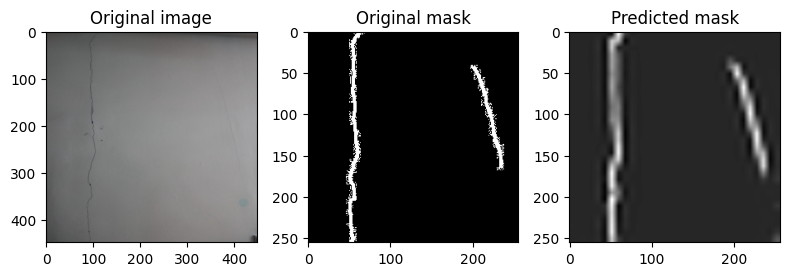

Model saved to: seg_model.pth
Epoch 2/3


  0%|          | 0/338 [00:00<?, ?it/s]

Train loss: 775.5688.


  0%|          | 0/84 [00:00<?, ?it/s]

Valid loss: 804.2636.
--------------------------------------------------


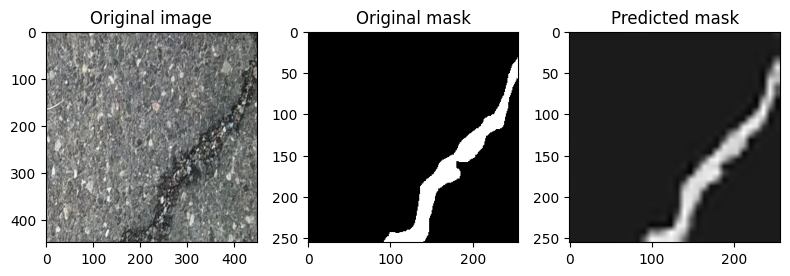

INFO: Early stopping counter 1 of 5
Epoch 3/3


  0%|          | 0/338 [00:00<?, ?it/s]

Train loss: 744.6677.


  0%|          | 0/84 [00:00<?, ?it/s]

Valid loss: 799.0933.
--------------------------------------------------


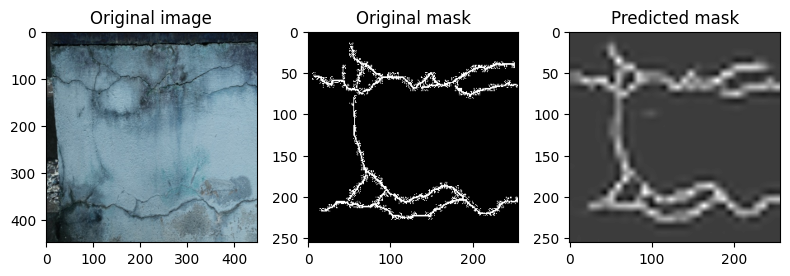

Model saved to: seg_model.pth


In [ ]:
train_losses, valid_losses = [], []

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []

    model.train()
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
        epoch_train_losses.append(batch_train_loss)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)

    print(f'Train loss: {epoch_train_loss:.4f}.')

    model.eval()
    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss = validate_one_batch(batch, model, criterion)
        epoch_valid_losses.append(batch_valid_loss)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}.')
    print('-'*50)

    validate_test_image(model, test)

    scheduler.step(epoch_valid_loss)
    early(epoch_valid_loss, model=model)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        model.load_state_dict(torch.load(path))
        break

## Inference

Using loss is a better metric to understand image segmentation compared to accuracy.

- Accuracy is a metric that measures the percentage of correctly classified pixels in an image. However, when it comes to image segmentation, the problem is not just about correctly classifying individual pixels, but also about correctly identifying the boundaries between different objects in the image.

- In image segmentation, the loss function measures the difference between the predicted segmentation map and the ground truth segmentation map. The loss function takes into account not only the correct classification of individual pixels but also the correct identification of object boundaries. This means that the loss function is more sensitive to the quality of the segmentation result and provides a more accurate measure of how well the model is performing.

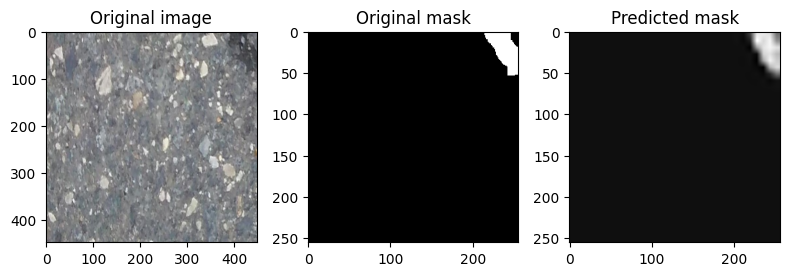

In [ ]:
validate_test_image(model, test)

# Results

In [ ]:
import cv2
import numpy as np

def resize_and_highlight_mask(image, mask):
    # Resize image to (256, 256) shape
    resized_image = cv2.resize(image, (256, 256))
    # Normalize mask to 0-255 range and convert to uint8 datatype
    normalized_mask = (mask / np.max(mask)) * 255
    normalized_mask = normalized_mask.astype(np.uint8)
    # Resize mask to (256, 256) shape
    resized_mask = cv2.resize(normalized_mask, (256, 256))
    # Convert resized_image to uint8 datatype
    resized_image = resized_image.astype(np.uint8)
    # Apply mask on the resized_image
    resized_image[:,:,0:1] = resized_image[:,:,0:1] + output
    return resized_image


def percentage_accuracy(image, mask, predicted_mask, plot=False):
    # Create a matrix of size (256, 256) with all elements as 255
    # to be used to calculate the total number of pixels in the image
    matrix = np.full((256, 256), 255, dtype=np.uint8)
    # Calculate the absolute difference between the ground truth mask and predicted mask
    abs_diff = np.abs(mask - predicted_mask[:,:,0])
    # Calculate the percentage of pixels that are different between the two masks
    percentage_diff = abs_diff.sum()/matrix.sum()*100
    # Calculate the accuracy as 100 minus the percentage difference
    accuracy = 100 - percentage_diff

    highlighted_output = resize_and_highlight_mask(image, output)
    if plot:
        plt.figure(figsize=(8, 4))
        plt.subplot(121)
        plt.title('Original image')
        plt.imshow(image)

        plt.subplot(122)
        plt.title('Predicted mask')
        plt.imshow(highlighted_output)

        plt.tight_layout()
        plt.show()

    # Return the accuracy value
    return accuracy


def percentage_precision(mask, predicted_mask):
    # create a matrix of size (256, 256) with all elements as 255
    # to be used to calculate the total number of pixels in the image
    white_matrix = np.full((256, 256), 255, dtype=np.uint8)

    # false positive: pixels that are predicted to be positive but are actually negative
    fp = predicted_mask[:,:,0] - mask
    # set all negative values to 0
    fp[fp < 0] = 0
    # calculate the percentage of false positive pixels
    fp_perc = fp.sum()/white_matrix.sum()*100

    # false negative: pixels that are predicted to be negative but are actually positive
    fn = predicted_mask[:,:,0] - mask
    # set all positive values to 0
    fn[fn > 0] = 0
    # take absolute value of the remaining negative values
    fn = np.abs(fn)
    # calculate the percentage of false negative pixels
    fn_perc = fn.sum()/white_matrix.sum()*100

    # true positive: pixels that are predicted to be positive and are actually positive
    tp = predicted_mask[:,:,0] + mask
    # set all values less than 255 to 0
    tp[tp<255] = 0
    # set all values greater than 255 to 255
    tp[tp>255] = 255
    # calculate the percentage of true positive pixels
    tp_perc = tp.sum()/white_matrix.sum()*100

    # calculate the precision as true positive divided by the sum of true positive and false positive
    precision = tp/(tp+fp)

    # return the precision value
    return 100-(np.nan_to_num(precision).mean()*100)


def percentage_recall(mask, predicted_mask):
    # Create a white matrix of size 256x256
    white_matrix = np.full((256, 256), 255, dtype=np.uint8)

    # Calculate false positives by subtracting the ground truth mask from the predicted mask
    fp = predicted_mask[:,:,0] - mask

    # Set negative values to 0, since we only want to count false positives
    fp[fp < 0] = 0

    # Calculate the percentage of false positives
    fp_perc = fp.sum()/white_matrix.sum()*100

    # Calculate false negatives by subtracting the predicted mask from the ground truth mask
    fn = predicted_mask[:,:,0] - mask

    # Set positive values to 0, since we only want to count false negatives
    fn[fn > 0] = 0

    # Calculate the absolute value of false negatives and the percentage of false negatives
    fn = np.abs(fn)
    fn_perc = fn.sum()/white_matrix.sum()*100

    # Calculate true positives by adding the predicted mask and the ground truth mask
    tp = predicted_mask[:,:,0] + mask

    # Set values less than 255 to 0, since we only want to count true positives
    tp[tp<255] = 0

    # Set values greater than 255 to 255, since we only want to count true positives
    tp[tp>255] = 255

    # Calculate the percentage of true positives
    tp_perc = tp.sum()/white_matrix.sum()*100

    # Calculate recall as true positives divided by the sum of true positives and false negatives
    recall = tp/(tp+fn)

    # Return recall
    return 100-(np.nan_to_num(recall).mean()*100)


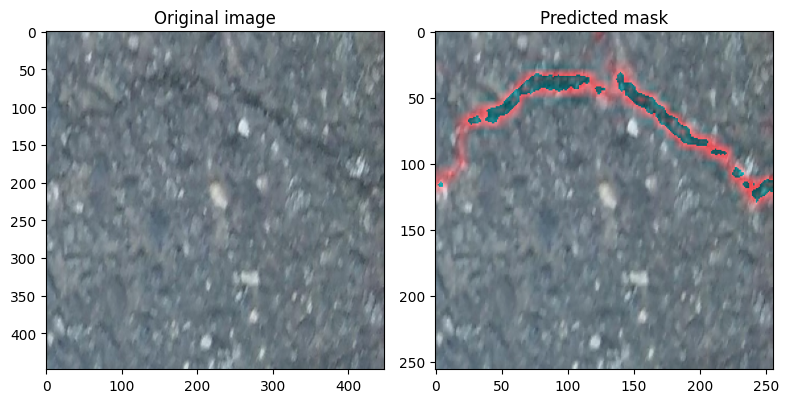

Accuracy: 96.36395099116307 
Precision:  94.74967271089554 
recall:  96.09411805868149


In [ ]:
dataset = test
idx = np.random.randint(len(dataset))
dataset = dataset.reset_index(drop=True)
row = dataset.loc[idx].squeeze()

image = cv2.imread(row['images'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_tensor = train_transforms(image).unsqueeze(0).to(device)

mask = cv2.imread(row['masks'])
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = cv2.resize(mask, (image_size, image_size))
_, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

model.eval()
output = model(image_tensor)
output = output['out'][0].cpu().detach().numpy().transpose(1,2,0)

# Calculate the percentage difference
accuracy = percentage_accuracy(image, mask, output, plot=True)
precision = percentage_precision(mask, output)
recall = percentage_recall(mask, output)

print('Accuracy:', accuracy,
      "\nPrecision: ", precision,
      "\nrecall: ", recall)

In [ ]:
from tqdm import tqdm

dataset = test
idx = np.random.randint(len(dataset))
dataset = dataset.reset_index(drop=True)

acc, pres, rec = [],[],[]
for idx in tqdm(range(len(dataset))):
  row = dataset.loc[idx].squeeze()
  image = cv2.imread(row['images'])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_tensor = train_transforms(image).unsqueeze(0).to(device)

  mask = cv2.imread(row['masks'])
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (image_size, image_size))
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  model.eval()
  output = model(image_tensor)
  output = output['out'][0].cpu().detach().numpy().transpose(1,2,0)

  # Calculate the percentage difference
  accuracy = percentage_accuracy(image, mask, output, plot=False)
  precision = percentage_precision(mask, output)
  recall = percentage_recall(mask, output)

  acc.append(accuracy)
  pres.append(precision)
  rec.append(recall)

print('\nTest Accuracy:', np.array(acc).mean(),
      "\nTest Precision: ", np.array(pres).mean(),
      "\n Test Recall: ", np.array(rec).mean())

100%|██████████| 2825/2825 [00:00<00:00, 2674093.61it/s]


Test Accuracy: 97.0471613200277 
Test Precision:  96.49216680960582 
 Test Recall:  97.3592701785674
